In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%cd ..

userData = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')
nonBorrower = pd.read_csv('non_borrower_user.csv')
loan = pd.read_csv('loan_activities.csv')

C:\Users\farel\AppData\Roaming\Python\Python310\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


c:\Users\farel\Downloads\datathon


In [2]:
trainLoan = userData.set_index('user_id').join(loan.set_index('user_id')).reset_index() #nyatuin data train sama loan
trainLoan = trainLoan.drop('pc8', axis=1) #drop kolom yang sama menurut heatmap
trainLoan = trainLoan.drop('pc9', axis=1) #drop kolom yang sama menurut heatmap
userData['-1_count'] = userData.isin([-1]).sum(axis=1) #nambahin kolom missing values (-1)
userData['is_loanreference'] = userData['user_id'].isin(loan["reference_contact"]) #nambahin kolom apakah usernya dijadiin loan reference
userData["has_borrowed"] = userData["user_id"].isin(loan["user_id"]) #nambahin kolom apakah usernya pernah minjem

nonLoan = nonBorrower.set_index('user_id').join(loan.set_index('user_id')).reset_index()

loan["referenced_is_non"] = loan["reference_contact"].isin(nonBorrower["user_id"])
loan["referenced_is_fraud"] = loan["reference_contact"].isin(userData.loc[userData["label"] == 1]["user_id"])

In [3]:
loanFraud = trainLoan.loc[trainLoan["label"]==1]
loanFraud = loanFraud[["user_id", "reference_contact", "loan_type", "ts"]]
loanNonFraud = trainLoan.loc[trainLoan["label"]==0]
loanNonFraud = loanNonFraud[["user_id", "reference_contact", "loan_type", "ts"]]

In [15]:
referenceInfo = pd.DataFrame()
referenceInfo["user_id"] = pd.concat([userData["user_id"], (nonBorrower["user_id"])])
referenceInfo["referenced_by_fraud"] = referenceInfo["user_id"].isin(loanFraud["reference_contact"])
referenceInfo["referenced_by_non"] = referenceInfo["user_id"].isin(loan.loc[loan.user_id.isin(nonBorrower.user_id)]["reference_contact"])
referenceInfo["referencing_fraud"] = referenceInfo["user_id"].isin(loan.loc[loan["referenced_is_fraud"] == 1]["user_id"])
referenceInfo["referencing_non"] = referenceInfo["user_id"].isin(loan.loc[loan["referenced_is_non"] == 1]["user_id"])
referenceInfo["label"] = referenceInfo["user_id"].isin(userData.loc[userData["label"] == 1]["user_id"])
referenceInfo.loc[referenceInfo['user_id'].isin(nonBorrower["user_id"])]['label'] = None

C:\Users\farel\AppData\Local\Temp\ipykernel_19380\3987793918.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  referenceInfo.loc[referenceInfo['user_id'].isin(nonBorrower["user_id"])]['label'] = None


In [16]:
referenceInfo['label'].value_counts()

label
False    3321991
True       10857
Name: count, dtype: int64

In [9]:
userData.head()


,user_id,pc0,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,...,pc11,pc12,pc13,pc14,pc15,pc16,label,-1_count,is_loanreference,has_borrowed
0,3,1.0,1.0,0.275,0.255,0.927273,0.4,0.260,0.040,0.254,...,0.072727,0.023077,0.078431,0.750000,0.018182,0.250000,0,0,True,False
1,5,0.0,0.0,0.430,0.365,0.848837,0.4,1.253,0.210,1.235,...,0.151163,0.014366,0.054795,0.500000,0.011628,0.250000,0,0,True,True
2,9,1.0,3.0,1.315,0.825,0.627376,0.9,2.385,0.128,2.270,...,0.372624,0.048218,0.054545,0.777778,0.003802,0.111111,0,0,True,True
3,10,0.0,5.0,-1.000,-1.000,-1.000000,-1.0,-1.000,-1.000,-1.000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0,14,True,True
4,17,1.0,1.0,0.235,0.160,0.680851,0.1,0.120,0.002,0.104,...,0.319149,0.133333,0.031250,-1.000000,-1.000000,-1.000000,0,3,True,True


In [92]:
def plot_grouped_bar_chart(df, x_col, hue_col, title):
    sns.countplot(data=df, x=x_col, hue=hue_col)
    plt.xlabel(x_col.capitalize())
    plt.ylabel('Count')
    plt.title(title)
    plt.legend(title=hue_col.capitalize())
    plt.show()

def draw_features(transactions, use_features):
    
    for feat in use_features:
        agg = transactions.groupby(['label', feat]).agg({'user_id': 'count'})
        df = agg.groupby(level=0).apply(lambda x: x / float(x.sum())).reset_index()
        
        plt.figure(figsize=(14, 10))
        ax = sns.factorplot(x=feat, y='user_id', hue='label', data=df, kind='bar', size = 6, aspect = 2)
        ax.fig.suptitle(feat.upper()+' by is_fraud - % of transactions')
        ax.set_xticklabels(rotation=20)
        plt.show()

#temp = userData.groupby(["pc0", "label"]).count()["user_id"].reset_index()
temp = userData.groupby(["label", "pc0"]).agg({'user_id': 'count'})

temp.groupby(['pc0']).apply(lambda x: x /x.sum()).reset_index()

#temp = userData.groupby(["pc0", "label"]).count()["user_id"].reset_index()
sns.barplot(data= temp, x="pc0", hue="label", y= "user_id")
# plt.show()

ValueError: cannot insert pc0, already exists

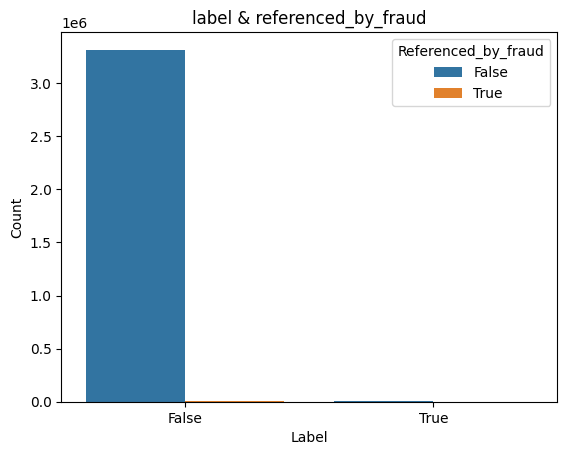

In [17]:
plot_grouped_bar_chart(referenceInfo, 'label', 'referenced_by_fraud', "label & referenced_by_fraud")

**KESIMPULAN**
- test ada yang minjem ada yang ga pernah minjem
- test ada yang direference dan ada yang ga pernah direference
- user yang direference oleh fraud belum tentu fraud
- user yang mereference fraud belum tentu fraud
- Orang yang ga minjem belum tentu non fraud

**Notes**
- label di referenceInfo dibikin -1 buat yang ada di dataframe nonBorrower